In [97]:
import warnings
warnings.filterwarnings('ignore')

import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Technical Analysis
from talib import RSI, BBANDS, ATR, NATR, MACD

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBRegressor
import joblib

# neural network
from tqdm import tqdm
import torch
import torch.nn as nn
  # our model
from LSTM import LSTM

# Data Preprocessing

In [2]:
# def read_tickers_sp500(file_path):
#     with open(file_path, 'r') as file:
#         tickers_sp500 = [line.strip() for line in file]
#     return tickers_sp500

# tickers_sp500 = read_tickers_sp500('tickers_sp500.txt')
# print(tickers_sp500)

In [3]:
# Download data

# Stocks list
# top 7 MarketCap in S&P500(^GSPC)
# tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META', 'AMD', 'INTC', 'NFLX', 'PYPL', 'ASML']
# tickers = tickers_sp500
start_date = '2014-05-01'
end_date = '2024-05-01'

df_prices_download = yf.download(tickers=tickers, start=start_date, end=end_date, group_by='ticker')

[*********************100%%**********************]  13 of 13 completed


In [4]:
# Format into large table
# col: OHLCV
# rows(multi-index): Ticker, Date

df_prices = df_prices_download.stack(level=0, dropna=False)
df_prices = df_prices.swaplevel(0, 1)
df_prices = df_prices.loc[tickers].sort_index(level='Ticker')
df_prices.dropna(inplace=True)

# Use 'Adj Close' instead of 'Close'
df_prices.drop('Close', axis=1, inplace=True)
df_prices.rename(columns={'Adj Close': 'Close'}, inplace=True)

df_prices

Price                     Open         High          Low        Close  \
Ticker Date                                                             
AAPL   2014-05-01    21.142857    21.242857    20.941429    18.581394   
       2014-05-02    21.155001    21.221430    21.061071    18.615946   
       2014-05-05    21.076429    21.464287    21.071428    18.879206   
       2014-05-06    21.492857    21.586071    21.228930    18.673441   
       2014-05-07    21.258928    21.331785    20.990356    18.608095   
...                        ...          ...          ...          ...   
^GSPC  2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883   
       2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922   
       2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961   
       2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922   
       2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941   

Price                    Volume  
Ticker Date                      
AAPL   2014-05-01  2.440480e+08  
       2014-05-02  1.915144e+08  
       2014-05-05  2.870672e+08  
       2014-05-06  3.745644e+08  
       2014-05-07  2.828644e+08  
...                         ...  
^GSPC  2024-04-24  3.656740e+09  
       2024-04-25  3.958050e+09  
       2024-04-26  3.604140e+09  
       2024-04-29  3.447450e+09  
       2024-04-30  4.082470e+09  

[32425 rows x 5 columns]

# Feature Engineering

### RSI - Relative Strength Index
RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold.

In [5]:
rsi = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(RSI)
df_prices['RSI'] = rsi

### Bollinger Bands
Bollinger Bands is a technical analysis tool used to determine where prices are high and low relative to each other.

In [6]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'BB_High': high,
                         'BB_Mid': mid, # SMA20
                         'BB_Low': low},
                        index=close.index)

bbands = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(compute_bb)
df_prices = pd.concat([df_prices, bbands], axis=1)

### ATR - Average True Range
The average true range (ATR) indicator shows the volatility of the market.

In [7]:
by_ticker = df_prices.groupby('Ticker', group_keys=False)

def compute_atr(stock_data):
    atr = ATR(stock_data.High,
              stock_data.Low,
              stock_data.Close,
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

df_prices['ATR'] = by_ticker.apply(compute_atr)
# Normalized Average True Range (NATR)
df_prices['NATR'] = by_ticker.apply(lambda x: NATR(high=x.High, low=x.Low, close=x.Close))

### MACD - Moving Average Convergence/Divergence

In [8]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

df_prices['MACD'] = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(compute_macd)

## Determine Investment Universe

### Dollar Volume

In [9]:
# Close: USD
# Volumn: Amount
df_prices['Dollar_Volume'] = (df_prices.loc[:, 'Close']
                           .mul(df_prices.loc[:, 'Volume'], axis=0))

df_prices.Dollar_Volume /= 1e6 # Dollar_Volume: Million USD

df_prices.dropna(inplace=True)

In [10]:
remian_cols = [c for c in df_prices.columns.unique(0) if c not in ['Dollar_Volume', 'Volume']]

# New data frame: 'data' - load to model
data = (
    pd.concat(
        [
        # avg(1M) Dollar_Volume
            df_prices.unstack("Ticker")
            .Dollar_Volume.resample('D')
            .mean()
            .stack("Ticker")
            .to_frame("Dollar_Volume"),
        # (Adj)Close & Technical Indicators
            df_prices.unstack("Ticker")[remian_cols]
            .resample('D')
            .last()
            .stack("Ticker")
        ],
        axis=1
    )
    .swaplevel()
    .sort_index(level='Ticker')
    .dropna()
)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31996 entries, ('AAPL', Timestamp('2014-06-18 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31996 non-null  float64
 1   Open           31996 non-null  float64
 2   High           31996 non-null  float64
 3   Low            31996 non-null  float64
 4   Close          31996 non-null  float64
 5   RSI            31996 non-null  float64
 6   BB_High        31996 non-null  float64
 7   BB_Mid         31996 non-null  float64
 8   BB_Low         31996 non-null  float64
 9   ATR            31996 non-null  float64
 10  NATR           31996 non-null  float64
 11  MACD           31996 non-null  float64
dtypes: float64(12)
memory usage: 3.2+ MB


## Monthly Return

In [11]:
outlier_cutoff = 0.01 # winsorize returns at the [1%, 99%]
# lags = [1, 3, 6, 12] # Month timeframe
lags = [1, 5, 10, 21, 42, 63] # Day timeframe
returns = []

for lag in lags:
    returns.append(data
                   .Close
                   .unstack('Ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('Ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'Return_{lag}d')
                   )

returns.append(data.High.unstack('Ticker').sort_index().pct_change(1).stack('Ticker')
               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
               .to_frame("High_Return"))
returns.append(data.Low.unstack('Ticker').sort_index().pct_change(1).stack('Ticker')
               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
               .to_frame("Low_Return"))
returns.append(data.Open.unstack('Ticker').sort_index().pct_change(1).stack('Ticker')
               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
               .to_frame("Open_Return"))

df_returns = pd.concat(returns, axis=1).swaplevel().sort_index(level='Ticker')
df_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31983 entries, ('AAPL', Timestamp('2014-06-19 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Return_1d    31983 non-null  float64
 1   Return_5d    31931 non-null  float64
 2   Return_10d   31866 non-null  float64
 3   Return_21d   31723 non-null  float64
 4   Return_42d   31450 non-null  float64
 5   Return_63d   31177 non-null  float64
 6   High_Return  31983 non-null  float64
 7   Low_Return   31983 non-null  float64
 8   Open_Return  31983 non-null  float64
dtypes: float64(9)
memory usage: 2.3+ MB


In [12]:
# merge returns -> data
# drop 'Close', use 'Returns' instead
data = data.join(df_returns).drop(['Close','High','Low','Open'], axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31177 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31177 non-null  float64
 1   RSI            31177 non-null  float64
 2   BB_High        31177 non-null  float64
 3   BB_Mid         31177 non-null  float64
 4   BB_Low         31177 non-null  float64
 5   ATR            31177 non-null  float64
 6   NATR           31177 non-null  float64
 7   MACD           31177 non-null  float64
 8   Return_1d      31177 non-null  float64
 9   Return_5d      31177 non-null  float64
 10  Return_10d     31177 non-null  float64
 11  Return_21d     31177 non-null  float64
 12  Return_42d     31177 non-null  float64
 13  Return_63d     31177 non-null  float64
 14  High_Return    31177 non-null  float64
 15  Low_Return     31177 non-null  float64
 16  Open_Return    

## Price Momentum
This factor computes the total return for a given number of prior trading days d.

In [13]:
# # Month timeframe
# for lag in [3, 6, 12]:
#     data[f'Momentum_{lag}'] = data[f'Return_{lag}m'].sub(data.Return_1m) # 3Xm - 1m
#     if lag > 3:
#         data[f'Momentum_3_{lag}'] = data[f'Return_{lag}m'].sub(data.Return_3m) # 6Xm - 3m

# Day timeframe
for lag in [5, 10, 21, 42, 63]:
    data[f'Momentum_{lag}'] = data[f'Return_{lag}d'].sub(data.Return_1d) # 3Xm - 1m
    if lag > 5:
        data[f'Momentum_5_{lag}'] = data[f'Return_{lag}d'].sub(data.Return_5d) # 6Xm - 3m

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31177 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31177 non-null  float64
 1   RSI            31177 non-null  float64
 2   BB_High        31177 non-null  float64
 3   BB_Mid         31177 non-null  float64
 4   BB_Low         31177 non-null  float64
 5   ATR            31177 non-null  float64
 6   NATR           31177 non-null  float64
 7   MACD           31177 non-null  float64
 8   Return_1d      31177 non-null  float64
 9   Return_5d      31177 non-null  float64
 10  Return_10d     31177 non-null  float64
 11  Return_21d     31177 non-null  float64
 12  Return_42d     31177 non-null  float64
 13  Return_63d     31177 non-null  float64
 14  High_Return    31177 non-null  float64
 15  Low_Return     31177 non-null  float64
 16  Open_Return    

## Date Indicators

In [14]:
dates = data.index.get_level_values('Date')
data['Year'] = dates.year
data['Month'] = dates.month

## Target: Holding Period Returns
1 day target holding period\
= to predict return in next 1 day (tomorrow)

In [15]:
data['target'] = data.groupby(level='Ticker')['Return_1d'].shift(-1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31164 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-29 00:00:00'))
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31164 non-null  float64
 1   RSI            31164 non-null  float64
 2   BB_High        31164 non-null  float64
 3   BB_Mid         31164 non-null  float64
 4   BB_Low         31164 non-null  float64
 5   ATR            31164 non-null  float64
 6   NATR           31164 non-null  float64
 7   MACD           31164 non-null  float64
 8   Return_1d      31164 non-null  float64
 9   Return_5d      31164 non-null  float64
 10  Return_10d     31164 non-null  float64
 11  Return_21d     31164 non-null  float64
 12  Return_42d     31164 non-null  float64
 13  Return_63d     31164 non-null  float64
 14  High_Return    31164 non-null  float64
 15  Low_Return     31164 non-null  float64
 16  Open_Return    

## Save data to local

In [16]:
# DATA_PATH = 'data'

# df_prices.to_csv(f'{DATA_PATH}/prices.csv', index=True)
# df_returns.to_csv(f'{DATA_PATH}/returns.csv', index=True)
# data.to_csv(f'{DATA_PATH}/data.csv', index=True)

In [17]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31996 entries, ('AAPL', Timestamp('2014-06-18 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           31996 non-null  float64
 1   High           31996 non-null  float64
 2   Low            31996 non-null  float64
 3   Close          31996 non-null  float64
 4   Volume         31996 non-null  float64
 5   RSI            31996 non-null  float64
 6   BB_High        31996 non-null  float64
 7   BB_Mid         31996 non-null  float64
 8   BB_Low         31996 non-null  float64
 9   ATR            31996 non-null  float64
 10  NATR           31996 non-null  float64
 11  MACD           31996 non-null  float64
 12  Dollar_Volume  31996 non-null  float64
dtypes: float64(13)
memory usage: 3.3+ MB


In [18]:
df_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31983 entries, ('AAPL', Timestamp('2014-06-19 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Return_1d    31983 non-null  float64
 1   Return_5d    31931 non-null  float64
 2   Return_10d   31866 non-null  float64
 3   Return_21d   31723 non-null  float64
 4   Return_42d   31450 non-null  float64
 5   Return_63d   31177 non-null  float64
 6   High_Return  31983 non-null  float64
 7   Low_Return   31983 non-null  float64
 8   Open_Return  31983 non-null  float64
dtypes: float64(9)
memory usage: 3.4+ MB


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31164 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-29 00:00:00'))
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31164 non-null  float64
 1   RSI            31164 non-null  float64
 2   BB_High        31164 non-null  float64
 3   BB_Mid         31164 non-null  float64
 4   BB_Low         31164 non-null  float64
 5   ATR            31164 non-null  float64
 6   NATR           31164 non-null  float64
 7   MACD           31164 non-null  float64
 8   Return_1d      31164 non-null  float64
 9   Return_5d      31164 non-null  float64
 10  Return_10d     31164 non-null  float64
 11  Return_21d     31164 non-null  float64
 12  Return_42d     31164 non-null  float64
 13  Return_63d     31164 non-null  float64
 14  High_Return    31164 non-null  float64
 15  Low_Return     31164 non-null  float64
 16  Open_Return    

# Split Data for Trading Evaluation
- **Train and Test Set:** 2014 - 2023 (9y)
- **Trading Evaluation:** 2023 - 2024 (1y)

In [20]:
data_reset = data.reset_index()
data_reset['Date'] = pd.to_datetime(data_reset['Date'])

split_date = pd.to_datetime('2023-05-01')

df_traintest= data_reset[data_reset['Date'] < split_date]
df_evaluate = data_reset[data_reset['Date'] >= split_date]

df_traintest.set_index(['Ticker', 'Date'], inplace=True)
df_evaluate.set_index(['Ticker', 'Date'], inplace=True)

print(df_traintest.shape)
print(df_evaluate.shape)

(27901, 29)
(3263, 29)


In [21]:
df_traintest.tail()

Dollar_Volume        RSI   BB_High    BB_Mid    BB_Low  \
Ticker Date                                                                 
^GSPC  2023-04-24   1.361475e+07  60.295857  8.345023  8.319051  8.293079   
       2023-04-25   1.619955e+07  48.152743  8.342452  8.320220  8.297987   
       2023-04-26   1.556296e+07  45.778748  8.338574  8.321275  8.303976   
       2023-04-27   1.550984e+07  57.286220  8.337419  8.322592  8.307765   
       2023-04-28   1.704400e+07  61.108979  8.338079  8.324035  8.309991   

                        ATR      NATR      MACD  Return_1d  Return_5d  ...  \
Ticker Date                                                            ...   
^GSPC  2023-04-24  0.188145  1.040110  0.794813   0.000852  -0.000689  ...   
       2023-04-25  0.256176  1.096520  0.601958  -0.015811  -0.004039  ...   
       2023-04-26  0.243170  1.093129  0.406061  -0.003841  -0.004789  ...   
       2023-04-27  0.357144  1.137637  0.422860   0.019566   0.000269  ...   
       2023-04-28  0.344622  1.121189  0.504772   0.008253   0.001734  ...   

                   Momentum_5_10  Momentum_21  Momentum_5_21  Momentum_42  \
Ticker Date                                                                 
^GSPC  2023-04-24       0.001367     0.001369       0.002910     0.000004   
       2023-04-25       0.003128     0.017003       0.005232     0.016160   
       2023-04-26       0.003907     0.004772       0.005720     0.004351   
       2023-04-27      -0.000532    -0.017636       0.001661    -0.018667   
       2023-04-28      -0.000967    -0.006606      -0.000086    -0.007086   

                   Momentum_5_42  Momentum_63  Momentum_5_63  Year  Month  \
Ticker Date                                                                 
^GSPC  2023-04-24       0.001545    -0.000395       0.001145  2023      4   
       2023-04-25       0.004389     0.016025       0.004254  2023      4   
       2023-04-26       0.005299     0.003998       0.004945  2023      4   
       2023-04-27       0.000630    -0.019276       0.000021  2023      4   
       2023-04-28      -0.000567    -0.007872      -0.001353  2023      4   

                     target  
Ticker Date                  
^GSPC  2023-04-24 -0.015811  
       2023-04-25 -0.003841  
       2023-04-26  0.019566  
       2023-04-27  0.008253  
       2023-04-28 -0.000386  

[5 rows x 29 columns]

In [22]:
df_evaluate.head()

Dollar_Volume        RSI   BB_High    BB_Mid    BB_Low  \
Ticker Date                                                                 
AAPL   2023-05-01    8839.642735  65.850668  5.136683  5.106882  5.077080   
       2023-05-02    8107.338241  62.442094  5.138516  5.107585  5.076655   
       2023-05-03   10834.418863  59.026386  5.139527  5.108129  5.076730   
       2023-05-04   13378.364450  54.166765  5.139789  5.108741  5.077692   
       2023-05-05   19537.403118  67.621349  5.148392  5.111360  5.074328   

                        ATR      NATR      MACD  Return_1d  Return_5d  ...  \
Ticker Date                                                            ...   
AAPL   2023-05-01 -0.349954  1.779095  1.201738  -0.000530   0.005101  ...   
       2023-05-02 -0.364242  1.782197  1.188692  -0.006191   0.005759  ...   
       2023-05-03 -0.304950  1.827134  1.115742  -0.006467   0.004467  ...   
       2023-05-04 -0.328565  1.832019  0.972344  -0.009913  -0.003131  ...   
       2023-05-05  0.175281  2.023185  1.178592   0.046927   0.004544  ...   

                   Momentum_5_10  Momentum_21  Momentum_5_21  Momentum_42  \
Ticker Date                                                                 
AAPL   2023-05-01      -0.002493     0.002607      -0.003024     0.004216   
       2023-05-02      -0.004522     0.007232      -0.004718     0.009630   
       2023-05-03      -0.004574     0.006833      -0.004101     0.008928   
       2023-05-04       0.002614     0.009959       0.003177     0.011698   
       2023-05-05       0.000521    -0.044153      -0.001769    -0.043699   

                   Momentum_5_42  Momentum_63  Momentum_5_63  Year  Month  \
Ticker Date                                                                 
AAPL   2023-05-01      -0.001415     0.003265      -0.002366  2023      5   
       2023-05-02      -0.002320     0.008685      -0.003265  2023      5   
       2023-05-03      -0.002006     0.008732      -0.002202  2023      5   
       2023-05-04       0.004915     0.011441       0.004659  2023      5   
       2023-05-05      -0.001316    -0.045054      -0.002670  2023      5   

                     target  
Ticker Date                  
AAPL   2023-05-01 -0.006191  
       2023-05-02 -0.006467  
       2023-05-03 -0.009913  
       2023-05-04  0.046927  
       2023-05-05 -0.000403  

[5 rows x 29 columns]

# Scaling Data
**Strategy:** Standard Score (Z-Score)

In [23]:
selected_data = df_traintest

norm_cols = selected_data.columns[:-1]  # Excluding Target column

# Create a ColumnTransformer to apply scaling only to specified columns
column_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), norm_cols)
    ],
    remainder='passthrough'  # Keep non-scaled columns unchanged
)

norm_data = column_transformer.fit_transform(selected_data)
norm_evaluate = column_transformer.fit_transform(df_evaluate)

print(norm_data)
print(norm_data.shape)
print(norm_evaluate.shape)

[[-2.65183896e-01  4.15202802e-01 -1.06183140e+00 ... -1.82413279e+00
   7.06913765e-01  2.06716311e-03]
 [-2.65778878e-01  4.79909303e-01 -1.06121538e+00 ... -1.82413279e+00
   7.06913765e-01 -8.15420898e-03]
 [-2.64942793e-01  1.09396824e-01 -1.06109917e+00 ... -1.82413279e+00
   7.06913765e-01  9.90283255e-04]
 ...
 [ 4.08765567e+00 -6.60074084e-01  2.60339240e+00 ...  1.78050829e+00
  -7.25945980e-01  1.95661497e-02]
 [ 4.07279372e+00  2.78900251e-01  2.60257198e+00 ...  1.78050829e+00
  -7.25945980e-01  8.25320275e-03]
 [ 4.50203911e+00  5.90825666e-01  2.60304103e+00 ...  1.78050829e+00
  -7.25945980e-01 -3.86106490e-04]]
(27901, 29)
(3263, 29)


# Model

(Sorry, I haven't implemented naive forecast)

## Train-Test Split
**Strategy:** Simple Split

Split arrays or matrices into random train and test subsets.

In [24]:
norm_X = norm_data[:, :-1]
norm_y = norm_data[:, -1]

X = df_traintest.drop('target', axis=1)
y = df_traintest.target

norm_X_train, norm_X_test, norm_y_train, norm_y_test = train_test_split(norm_X, norm_y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print("Train Set:", X_train.shape, y_train.shape)
print("Test Set:", X_test.shape, y_test.shape)

Train Set: (20925, 28) (20925,)
Test Set: (6976, 28) (6976,)


## Train Model

Training models without hyperparameter tuning for improvement comparision.

In [25]:
if torch.cuda.is_available():
    # Nvidia CUDA
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Apple Metal
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f'Device: {device}')

Device: mps


In [26]:
# naive_model = None
linear_model = LinearRegression()
svr_model = SVR()
rfr_model = RandomForestRegressor()
xgb_model = XGBRegressor()

models = {
    'LinearRegression': linear_model,
    'SVR': svr_model,
    'RFR': rfr_model,
    'XGB': xgb_model,
}

In [27]:
results = dict()

for name, model in models.items():
    print(f"Training {name} ...")

    if (name == "SVR"):
        model.fit(norm_X_train, norm_y_train)
        y_pred_test = model.predict(norm_X_test)

    else:
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)

    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = ( np.mean(np.sign(y_pred_test) == np.sign(y_test)) )

    results[name] = {
        'model': model,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

Training LinearRegression ...
Training SVR ...
Training RFR ...
Training XGB ...


Model: LinearRegression
MAE: 0.0158
MSE: 0.0005
RMSE: 0.0221
Direction: 0.5212


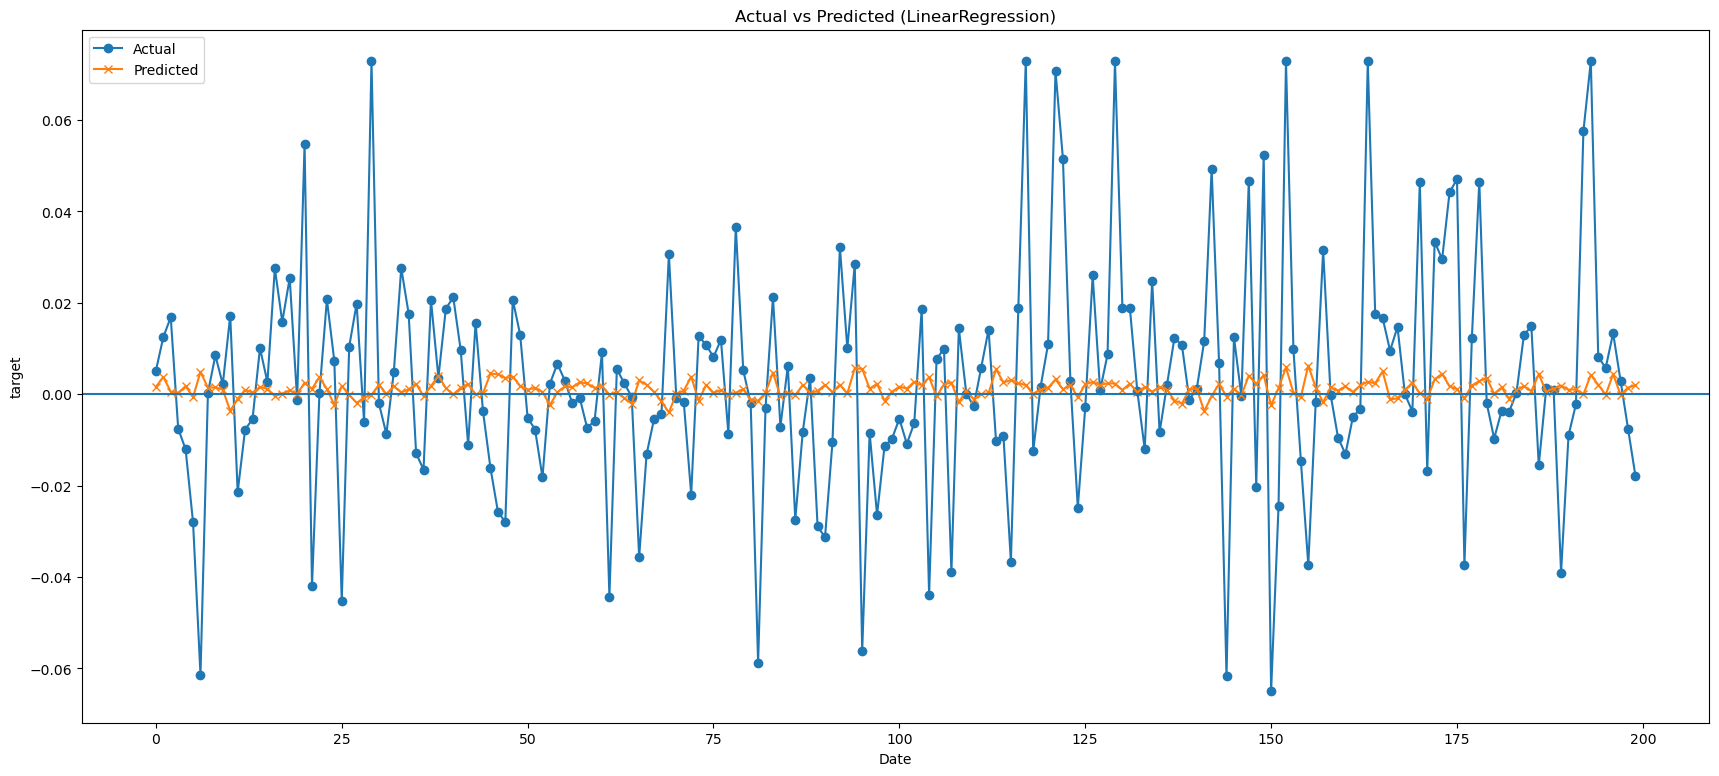

Model: SVR
MAE: 0.0161
MSE: 0.0005
RMSE: 0.0223
Direction: 0.5198


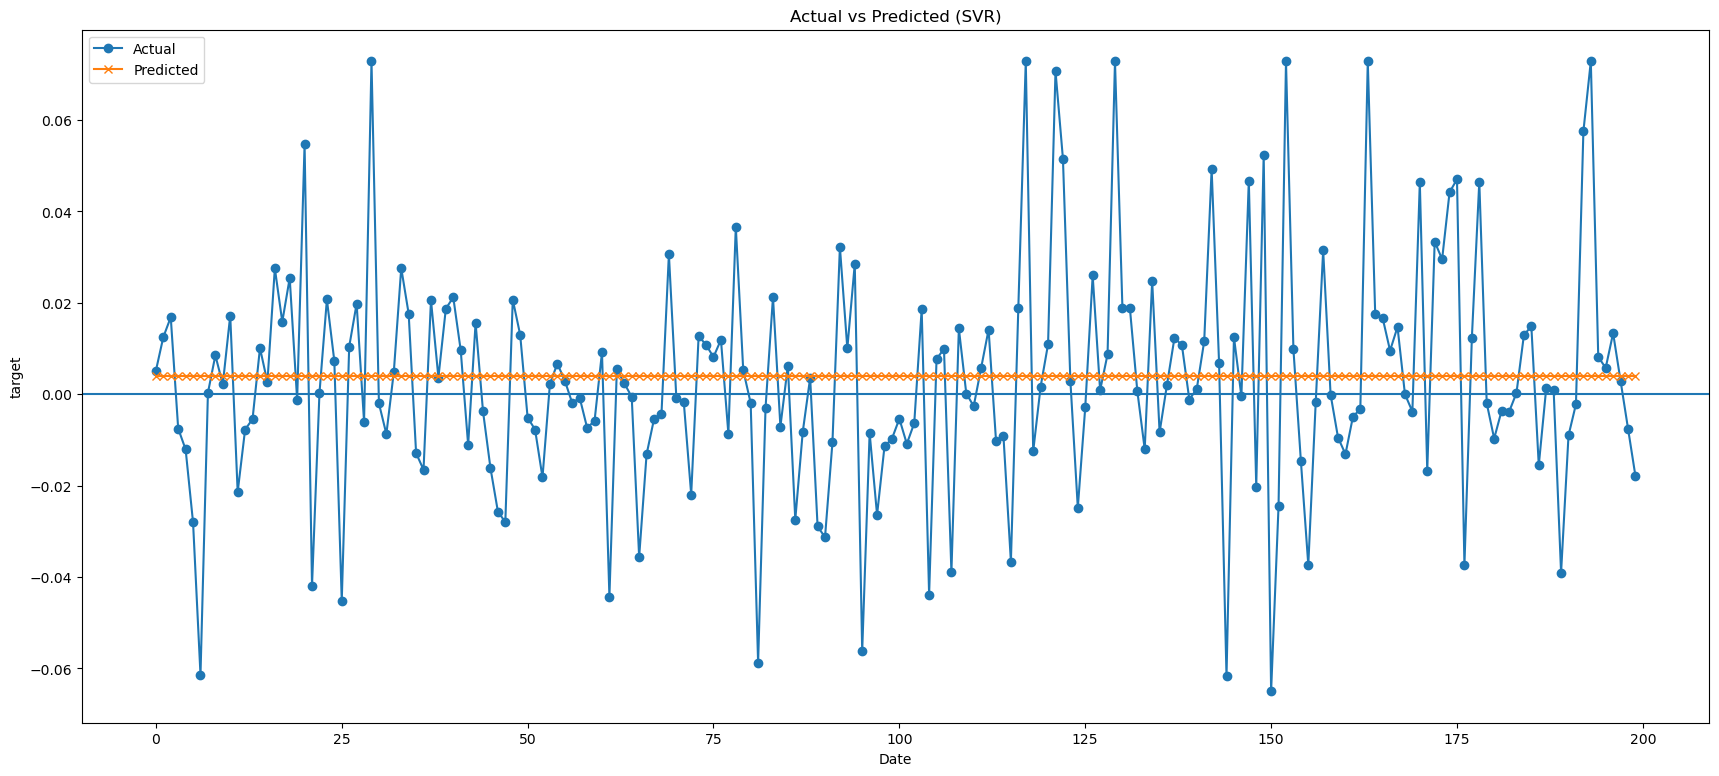

Model: RFR
MAE: 0.0157
MSE: 0.0005
RMSE: 0.0220
Direction: 0.5360


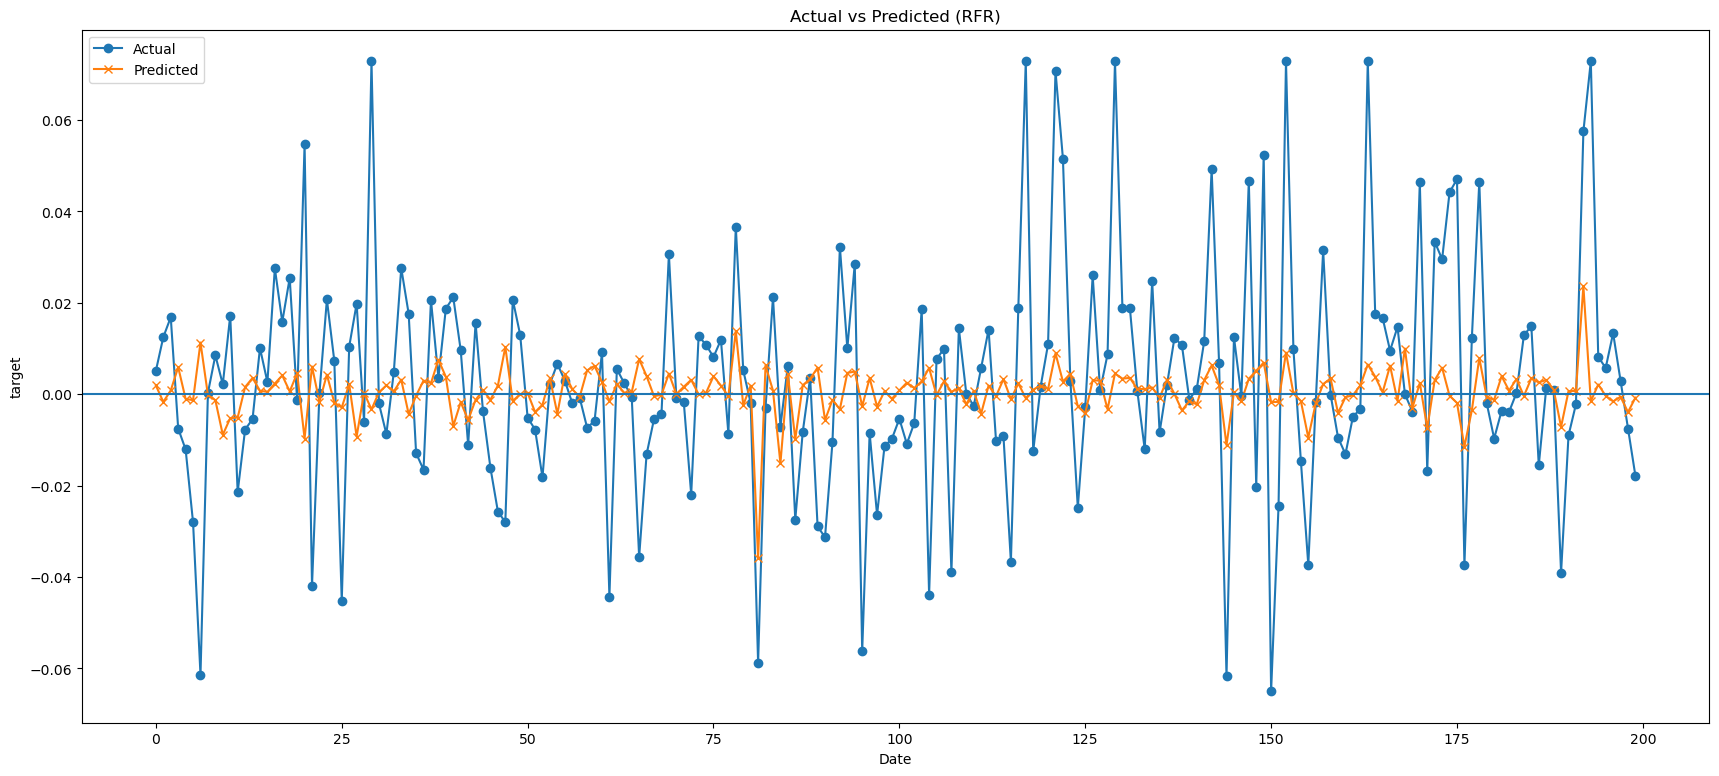

Model: XGB
MAE: 0.0161
MSE: 0.0005
RMSE: 0.0227
Direction: 0.5413


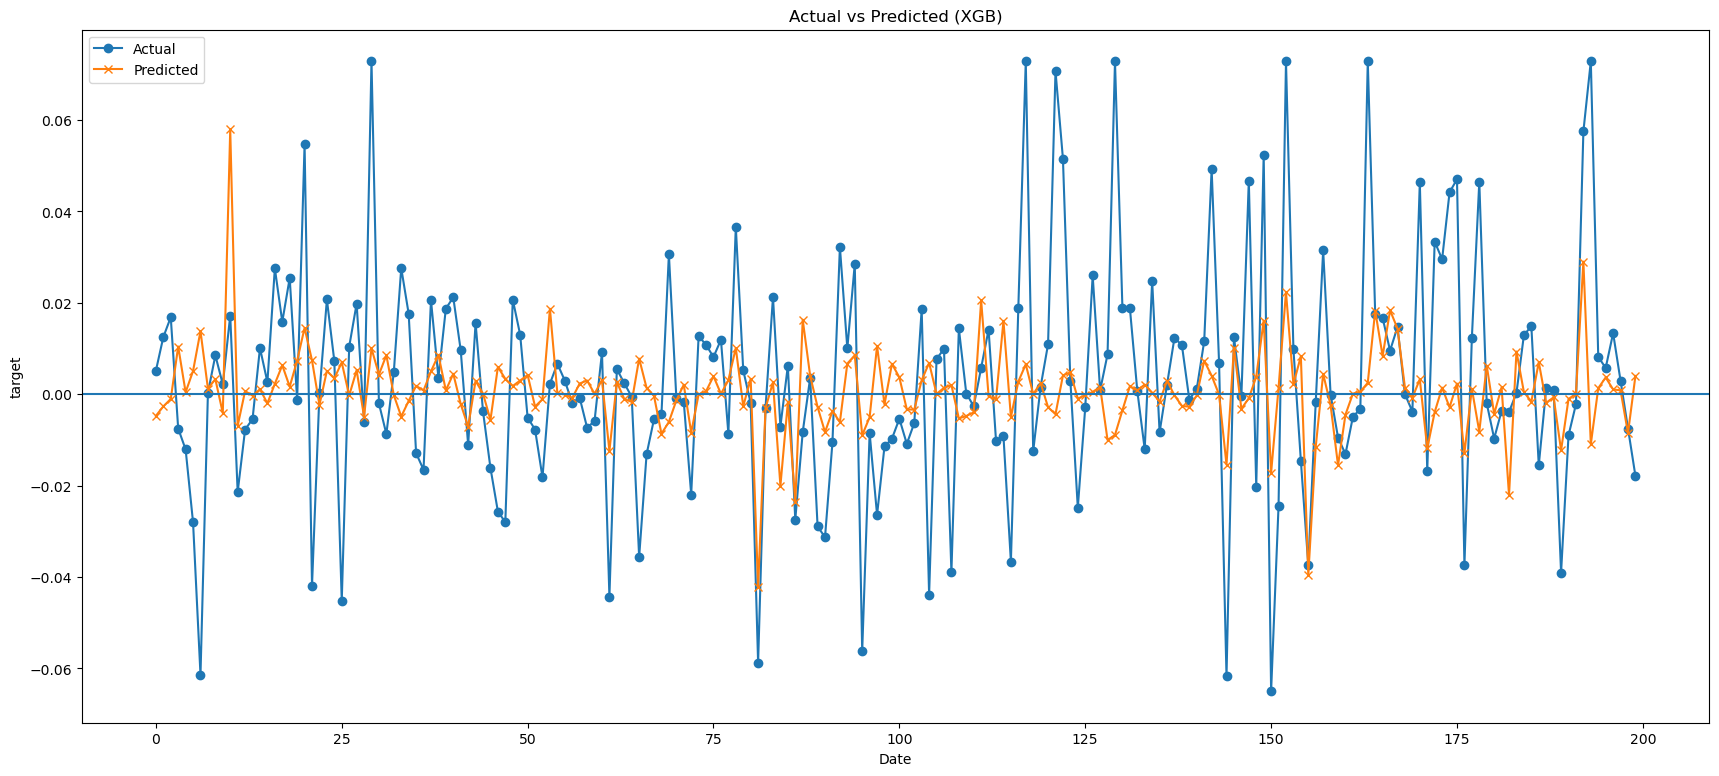

In [28]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"Direction: {metrics['direction']:.4f}")

    plt.figure(figsize=(21, 9))
    # plt.plot(range(len(y_test)), y_test, label='Actual', marker='o')
    # plt.plot(range(len(y_test)), metrics['y_pred_test'], label='Predicted', marker='x')

    n_data = 200
    plt.plot(range(n_data), y_test[:n_data], label='Actual', marker='o')
    plt.plot(range(n_data), metrics['y_pred_test'][:n_data], label='Predicted', marker='x')
    plt.axhline(y=0)

    plt.xlabel('Date')
    plt.ylabel('target')
    plt.title(f'Actual vs Predicted ({name})')
    plt.legend()
    plt.show()

# Hyper Parameter Tuning
**Strategy**: Grid Search CV

Exhaustive search over specified parameter values for an estimator.

In [29]:
tuned_linear_model = LinearRegression(fit_intercept=True)
tuned_svr_model = SVR(epsilon=0.01)
tuned_rfr_model = RandomForestRegressor(min_samples_leaf=9)
tuned_xgb_model = XGBRegressor(eta=0.1, max_depth=5)

tuned_models = {
    'tuned_LinearRegression': tuned_linear_model,
    'tuned_SVR': tuned_svr_model,
    'tuned_RFR': tuned_rfr_model,
    'tuned_XGB': tuned_xgb_model
}

In [30]:
tuned_results = dict()

for name, model in tuned_models.items():
    print(f"Training {name} ...")

    if (name == "tuned_SVR"):
        model.fit(norm_X_train, norm_y_train * 10)
        y_pred_test = model.predict(norm_X_test) / 10

    else:
        model.fit(X_train, y_train * 10)
        y_pred_test = model.predict(X_test) / 10

    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = ( np.mean(np.sign(y_pred_test) == np.sign(y_test)) )

    # incase this model needs to be saved
    # joblib.dump(model, f"./models/tuned/{name}.sav")

    tuned_results[name] = {
        'model': model,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

Training tuned_LinearRegression ...
Training tuned_SVR ...
Training tuned_RFR ...
Training tuned_XGB ...


Model: tuned_LinearRegression
MAE: 0.0158
MSE: 0.0005
RMSE: 0.0221
Direction: 0.5212


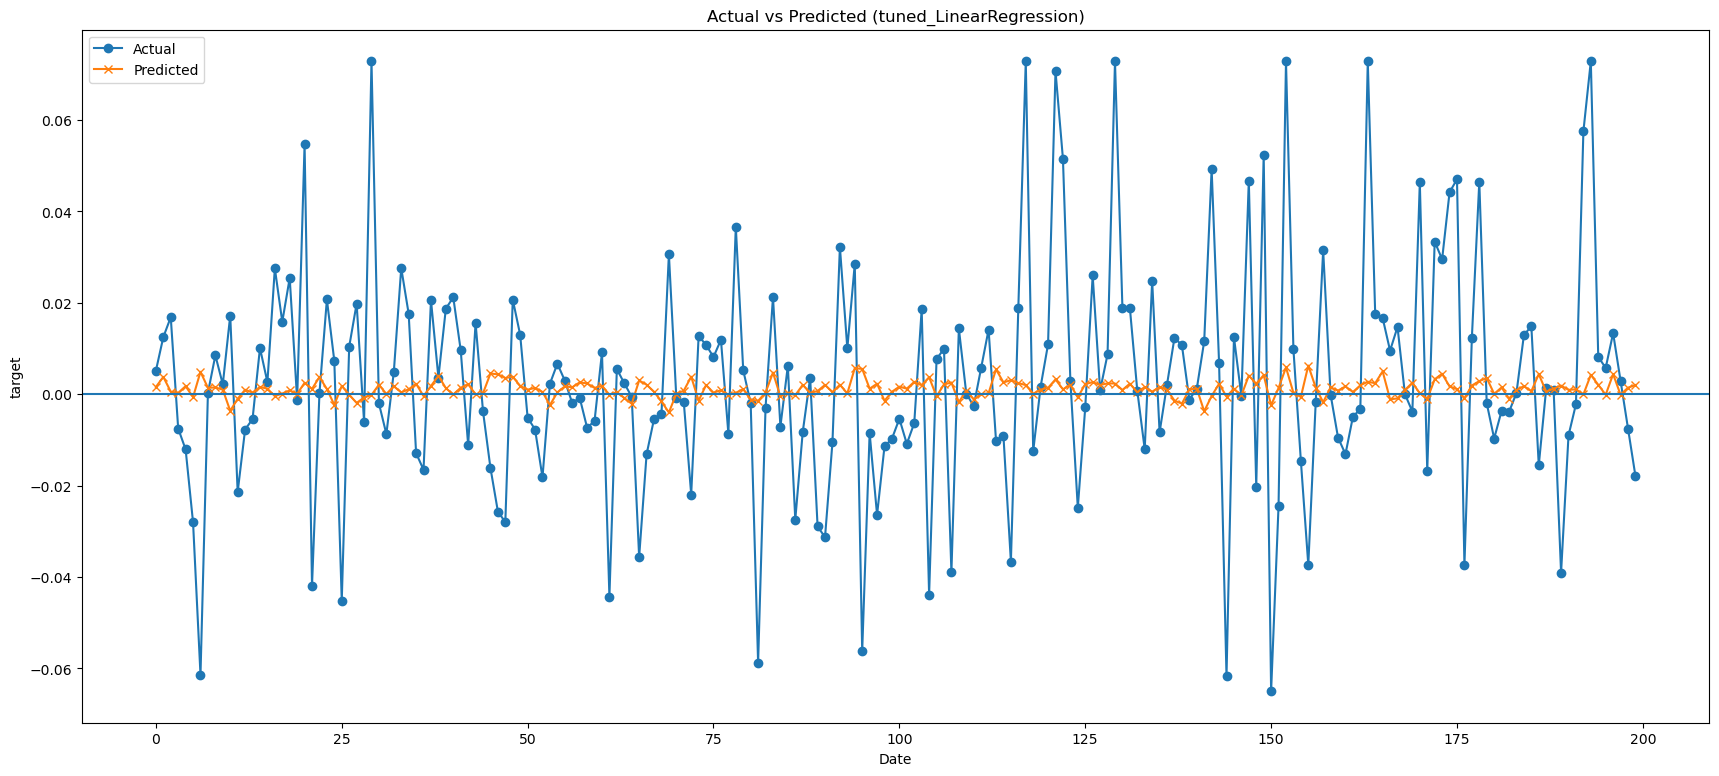

Model: tuned_SVR
MAE: 0.0158
MSE: 0.0005
RMSE: 0.0224
Direction: 0.5417


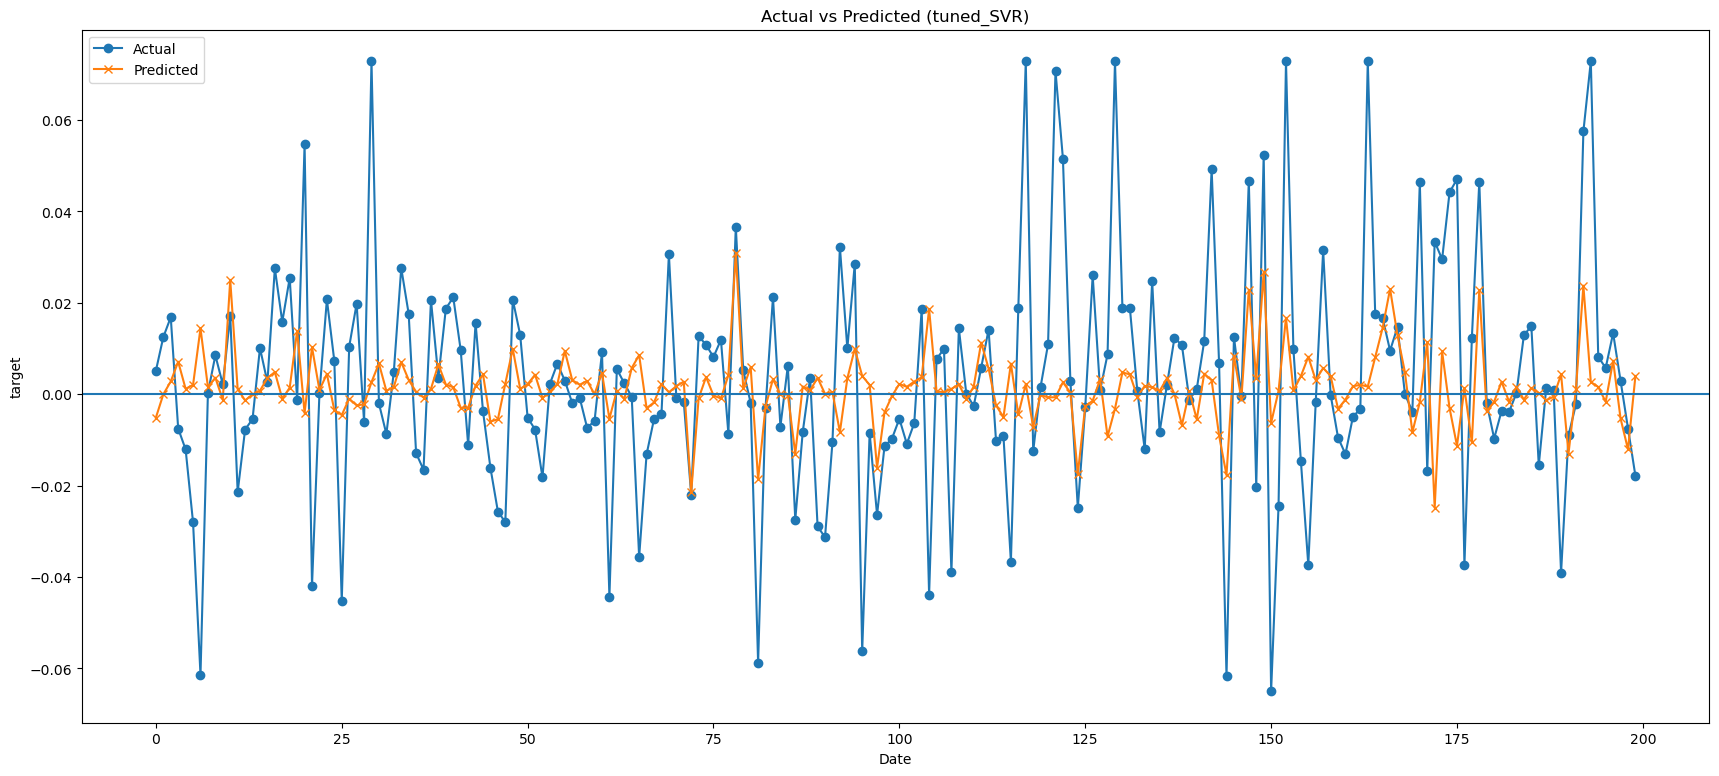

Model: tuned_RFR
MAE: 0.0156
MSE: 0.0005
RMSE: 0.0219
Direction: 0.5466


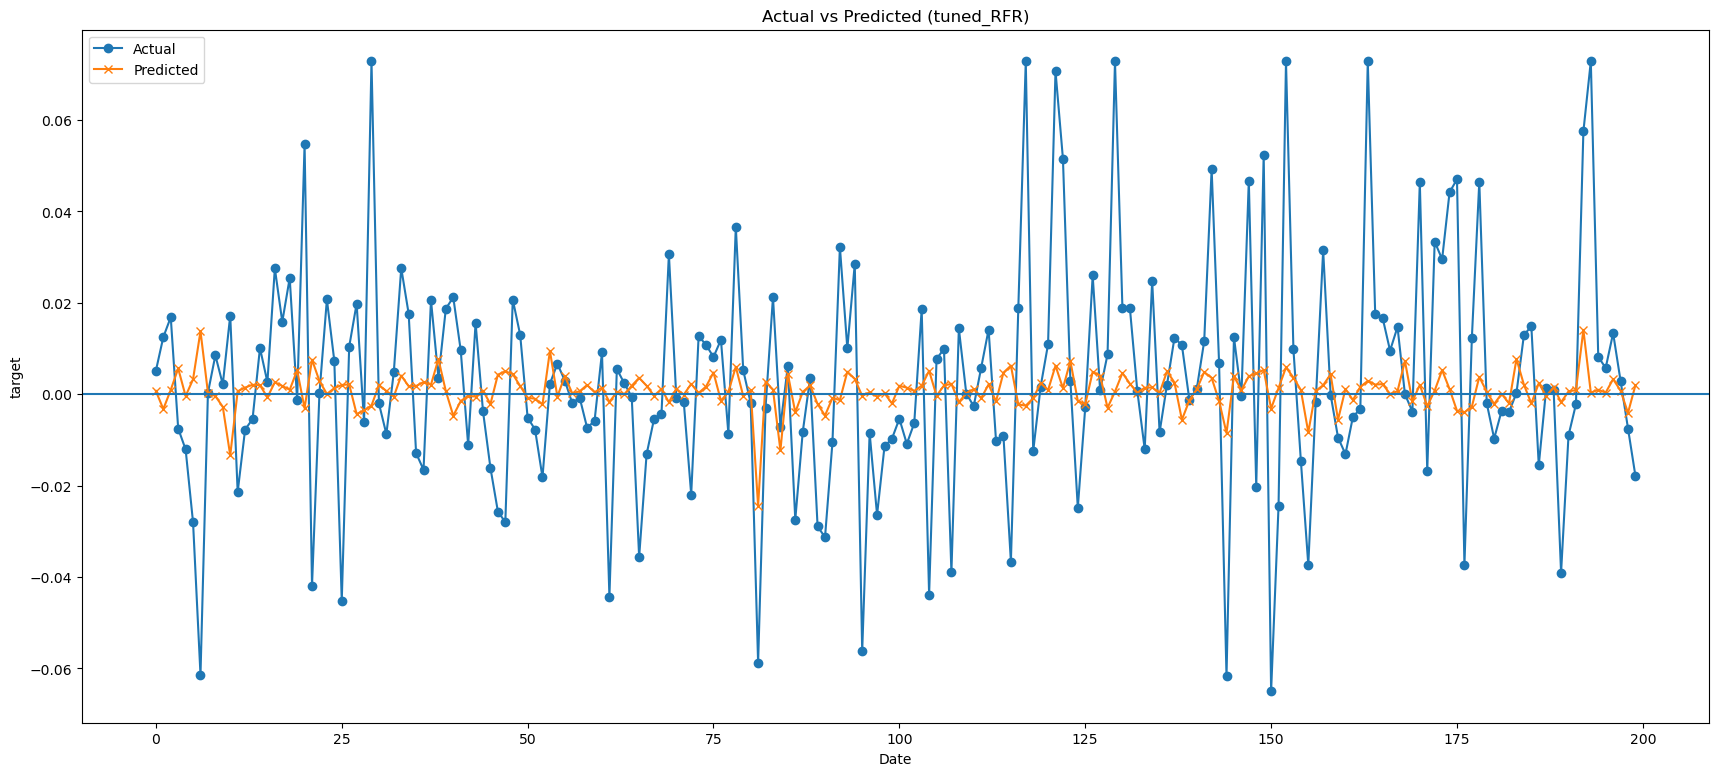

Model: tuned_XGB
MAE: 0.0156
MSE: 0.0005
RMSE: 0.0218
Direction: 0.5370


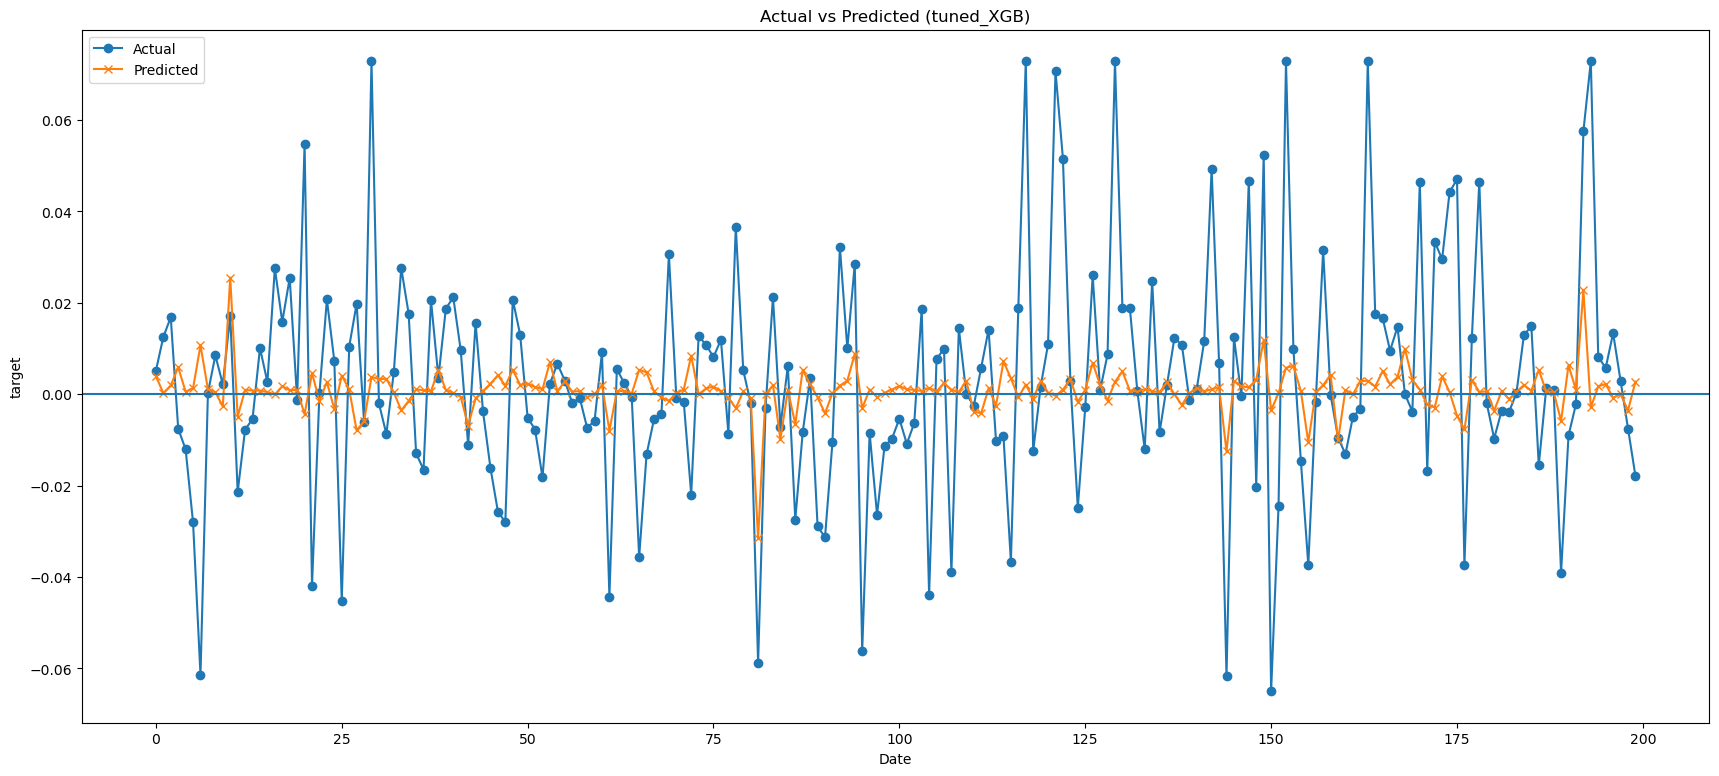

In [31]:
for name, metrics in tuned_results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"Direction: {metrics['direction']:.4f}")

    plt.figure(figsize=(21, 9))
    # plt.plot(range(len(y_test)), y_test, label='Actual', marker='o')
    # plt.plot(range(len(y_test)), metrics['y_pred_test'], label='Predicted', marker='x')

    n_data = 200
    plt.plot(range(n_data), y_test[:n_data], label='Actual', marker='o')
    plt.plot(range(n_data), metrics['y_pred_test'][:n_data], label='Predicted', marker='x')
    plt.axhline(y=0)

    plt.xlabel('Date')
    plt.ylabel('target')
    plt.title(f'Actual vs Predicted ({name})')
    plt.legend()
    plt.show()

# Predicted Data

In [39]:
predict_traintest = dict()
predict_evaluate = dict()

norm_evaluate_X = norm_evaluate[:, :-1]
norm_evaluate_y = norm_evaluate[-1]

evaluate_X = df_evaluate.drop('target', axis=1)
evaluate_y = df_evaluate.target

# Naive Forecast
print(f"Predicting NaiveForecast ...")
y_pred_traintest = data['Return_1d']
y_pred_evaluate = data['Return_1d']
predict_traintest['NaiveForecast'] = y_pred_traintest
predict_evaluate['NaiveForecast'] = y_pred_evaluate

for name, metrics in tuned_results.items():
    print(f"Predicting {name} ...")
    if (name == "tuned_SVR"):
        y_pred_traintest = metrics['model'].predict(norm_X) / 10
        y_pred_evaluate = metrics['model'].predict(norm_evaluate_X) / 10
    else:
        y_pred_traintest = metrics['model'].predict(X) / 10
        y_pred_evaluate = metrics['model'].predict(evaluate_X) / 10

    predict_traintest[name] = y_pred_traintest
    predict_evaluate[name] = y_pred_evaluate

df_predict_traintest = pd.DataFrame(predict_traintest, index=df_traintest.index)
df_predict_evaluate = pd.DataFrame(predict_evaluate, index=df_evaluate.index)

Predicting NaiveForecast ...
Predicting tuned_LinearRegression ...
Predicting tuned_SVR ...
Predicting tuned_RFR ...
Predicting tuned_XGB ...


In [60]:
all_models = { # model_name: model
    'NaiveForecast': None,
    'tuned_LinearRegression': tuned_linear_model,
    'tuned_SVR': tuned_svr_model,
    'tuned_RFR': tuned_rfr_model,
    'tuned_XGB': tuned_xgb_model
}

df_predicted = pd.concat([df_predict_traintest, df_predict_evaluate])

# Trading

## Simple Strategy
- Position (Buy/Sell/do nothing) base on predicted '(log)return' of the next day
    - return > 0 : buy
    - return = 0 : do nothing
    - return < 0 : sell
- buy/sell all of portfolio in each transaction
- no short position

In [87]:
df_trading = None # init # for support duplicate run
df_trading = pd.DataFrame(data['target']).rename(columns={'target': 'Actual'})
df_trading = df_trading.join(df_predicted) # merge

# Trading return
df_trading_return = None # init
df_signal = ( df_predicted > 0 ).astype(int) # 1: Buy, 0: Sell
df_trading_return = df_signal.mul(df_trading['Actual'], axis=0)
df_trading_return.columns = ['return_' + col for col in df_signal.columns]
df_trading = df_trading.join(df_trading_return) # merge

# Calculate cumulative return for each model
df_cumulative_return = None # init
df_cumulative_return = df_trading_return.groupby('Ticker').cumsum()
df_cumulative_return = df_cumulative_return.add(1)
df_cumulative_return.columns = ['cumulative_' + col for col in df_cumulative_return.columns]
df_trading = df_trading.join(df_cumulative_return)

In [94]:
df_cumulative_return

cumulative_return_NaiveForecast  \
Ticker Date                                          
AAPL   2014-09-17                         1.002067   
       2014-09-18                         0.993913   
       2014-09-19                         0.993913   
       2014-09-22                         1.009548   
       2014-09-23                         1.000876   
...                                            ...   
^GSPC  2024-04-23                         1.218150   
       2024-04-24                         1.213574   
       2024-04-25                         1.213574   
       2024-04-26                         1.216752   
       2024-04-29                         1.201022   

                   cumulative_return_tuned_LinearRegression  \
Ticker Date                                                   
AAPL   2014-09-17                                  1.002067   
       2014-09-18                                  0.993913   
       2014-09-19                                  0.993913   
       2014-09-22                                  1.009548   
       2014-09-23                                  1.009548   
...                                                     ...   
^GSPC  2024-04-23                                  2.184858   
       2024-04-24                                  2.180281   
       2024-04-25                                  2.190490   
       2024-04-26                                  2.193669   
       2024-04-29                                  2.177938   

                   cumulative_return_tuned_SVR  cumulative_return_tuned_RFR  \
Ticker Date                                                                   
AAPL   2014-09-17                     1.000000                     1.000000   
       2014-09-18                     1.000000                     1.000000   
       2014-09-19                     1.000000                     1.000000   
       2014-09-22                     1.000000                     1.000000   
       2014-09-23                     1.000000                     1.000000   
...                                        ...                          ...   
^GSPC  2024-04-23                     4.089722                     7.503311   
       2024-04-24                     4.089722                     7.503311   
       2024-04-25                     4.089722                     7.513520   
       2024-04-26                     4.089722                     7.513520   
       2024-04-29                     4.089722                     7.513520   

                   cumulative_return_tuned_XGB  
Ticker Date                                     
AAPL   2014-09-17                     1.000000  
       2014-09-18                     1.000000  
       2014-09-19                     1.000000  
       2014-09-22                     1.000000  
       2014-09-23                     1.000000  
...                                        ...  
^GSPC  2024-04-23                     3.694893  
       2024-04-24                     3.694893  
       2024-04-25                     3.705102  
       2024-04-26                     3.708281  
       2024-04-29                     3.692550  

[31164 rows x 5 columns]

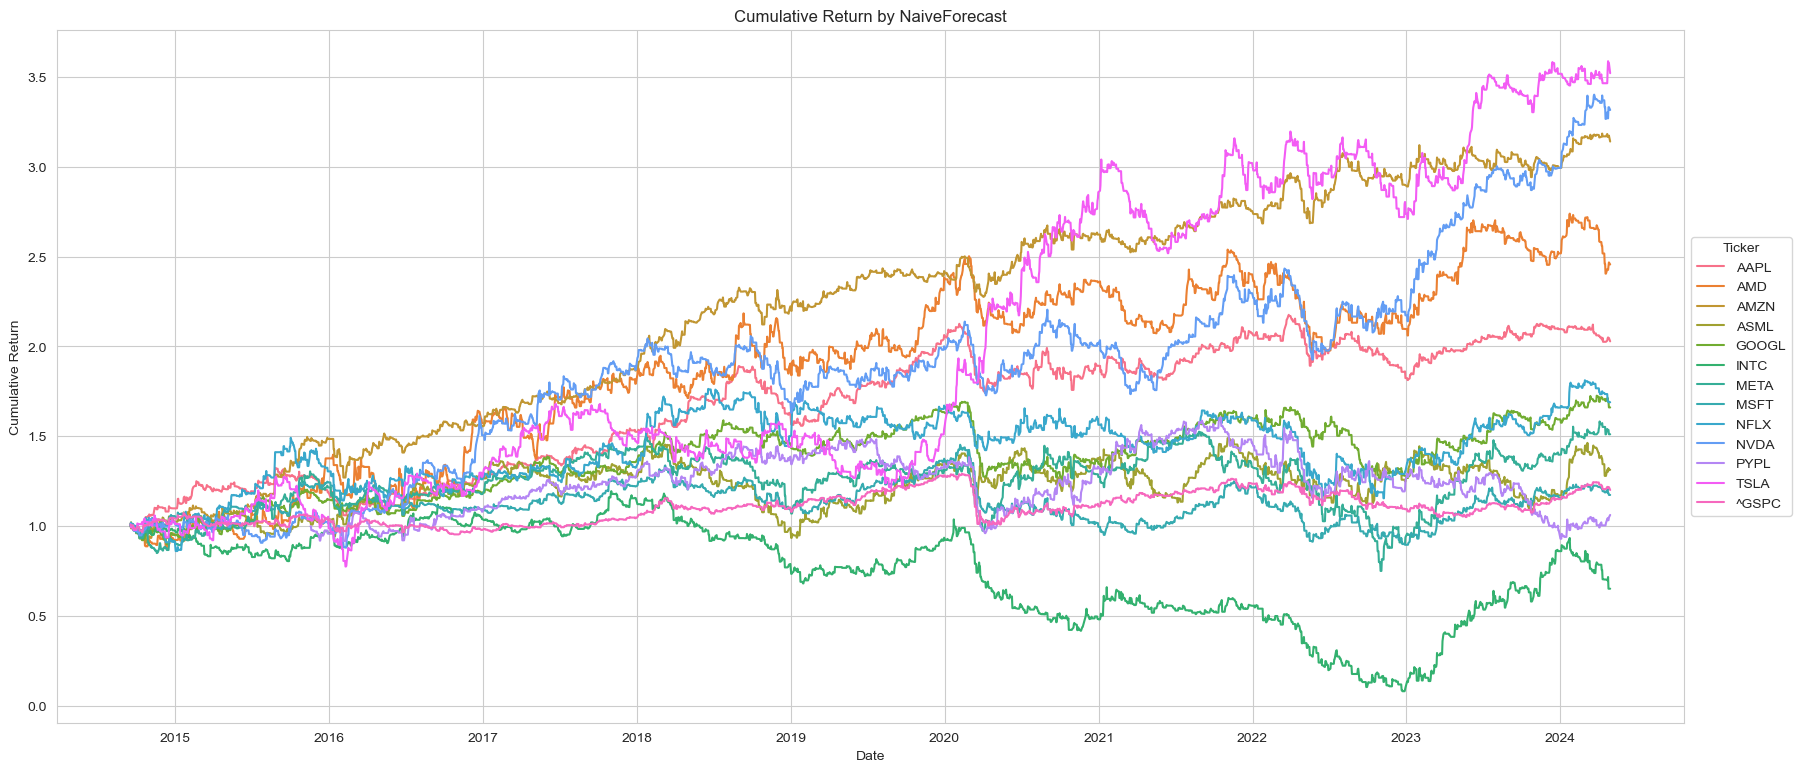

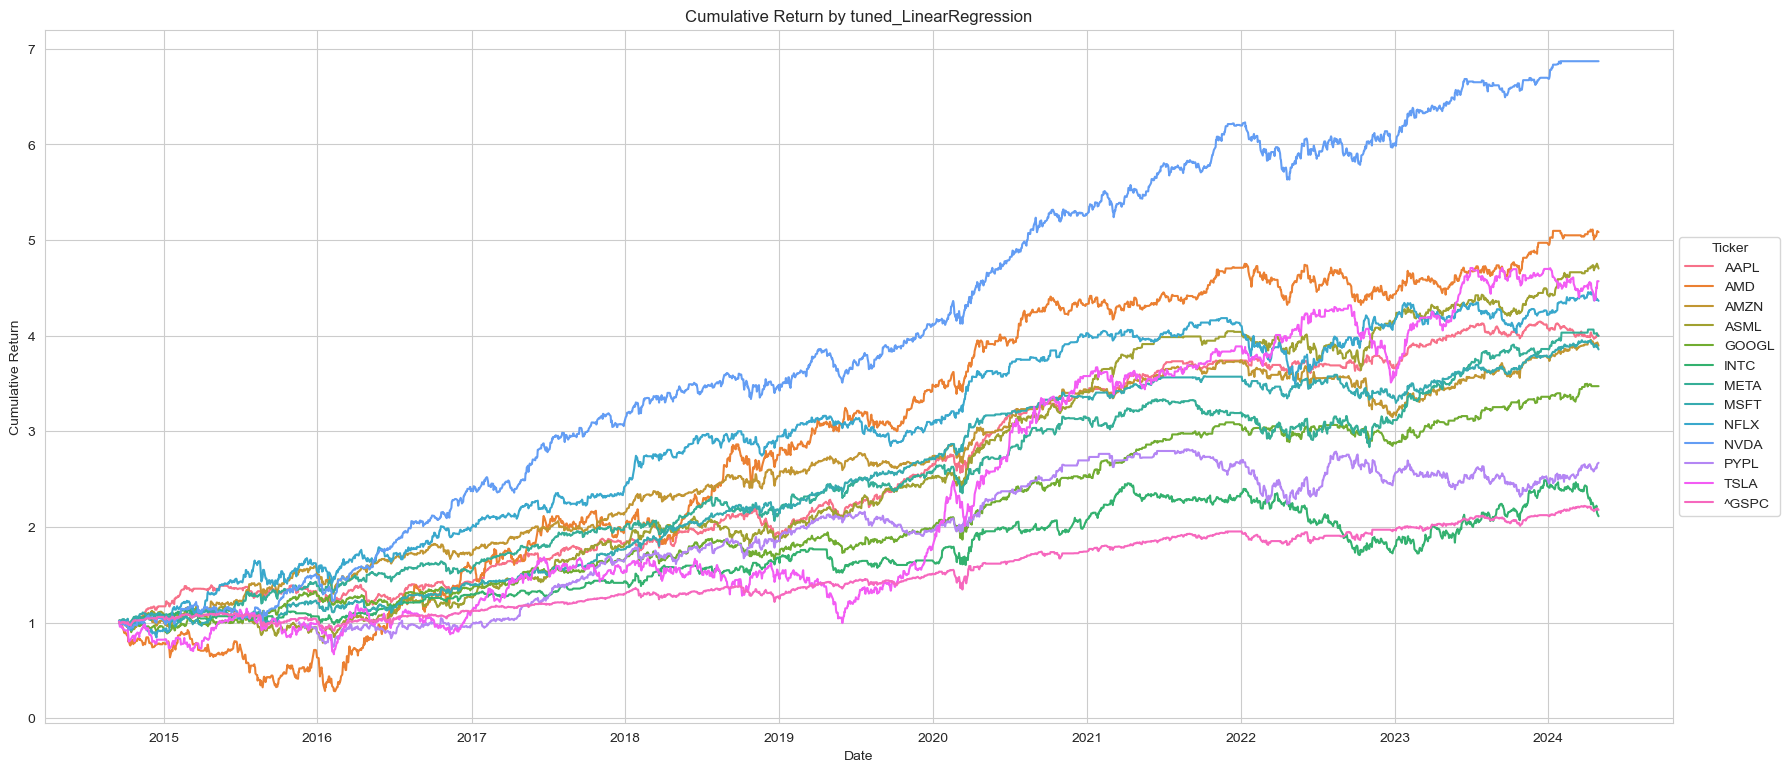

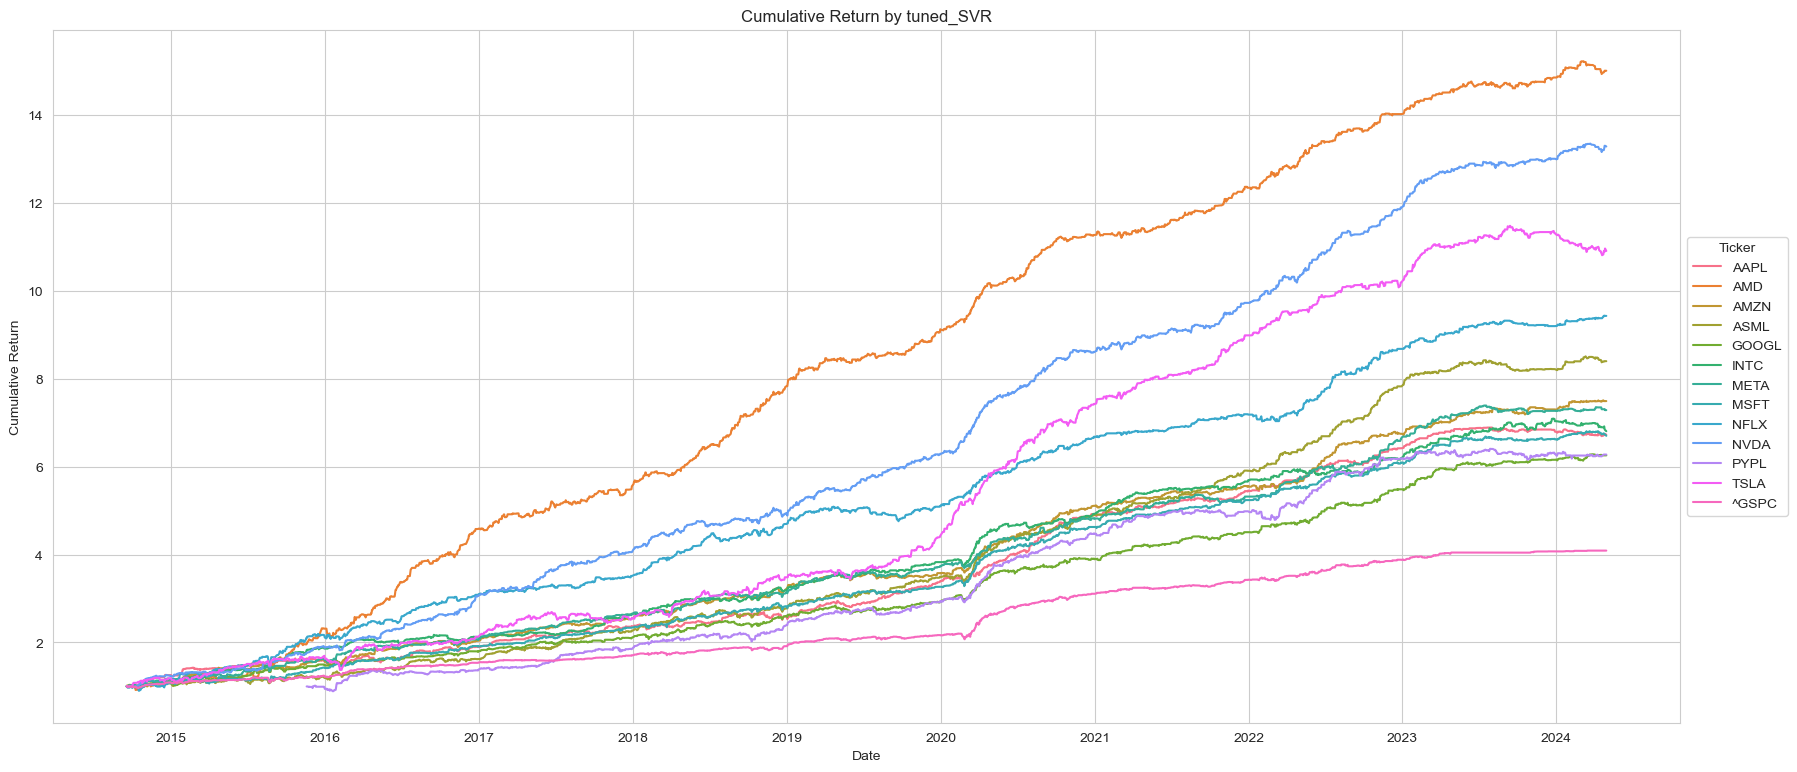

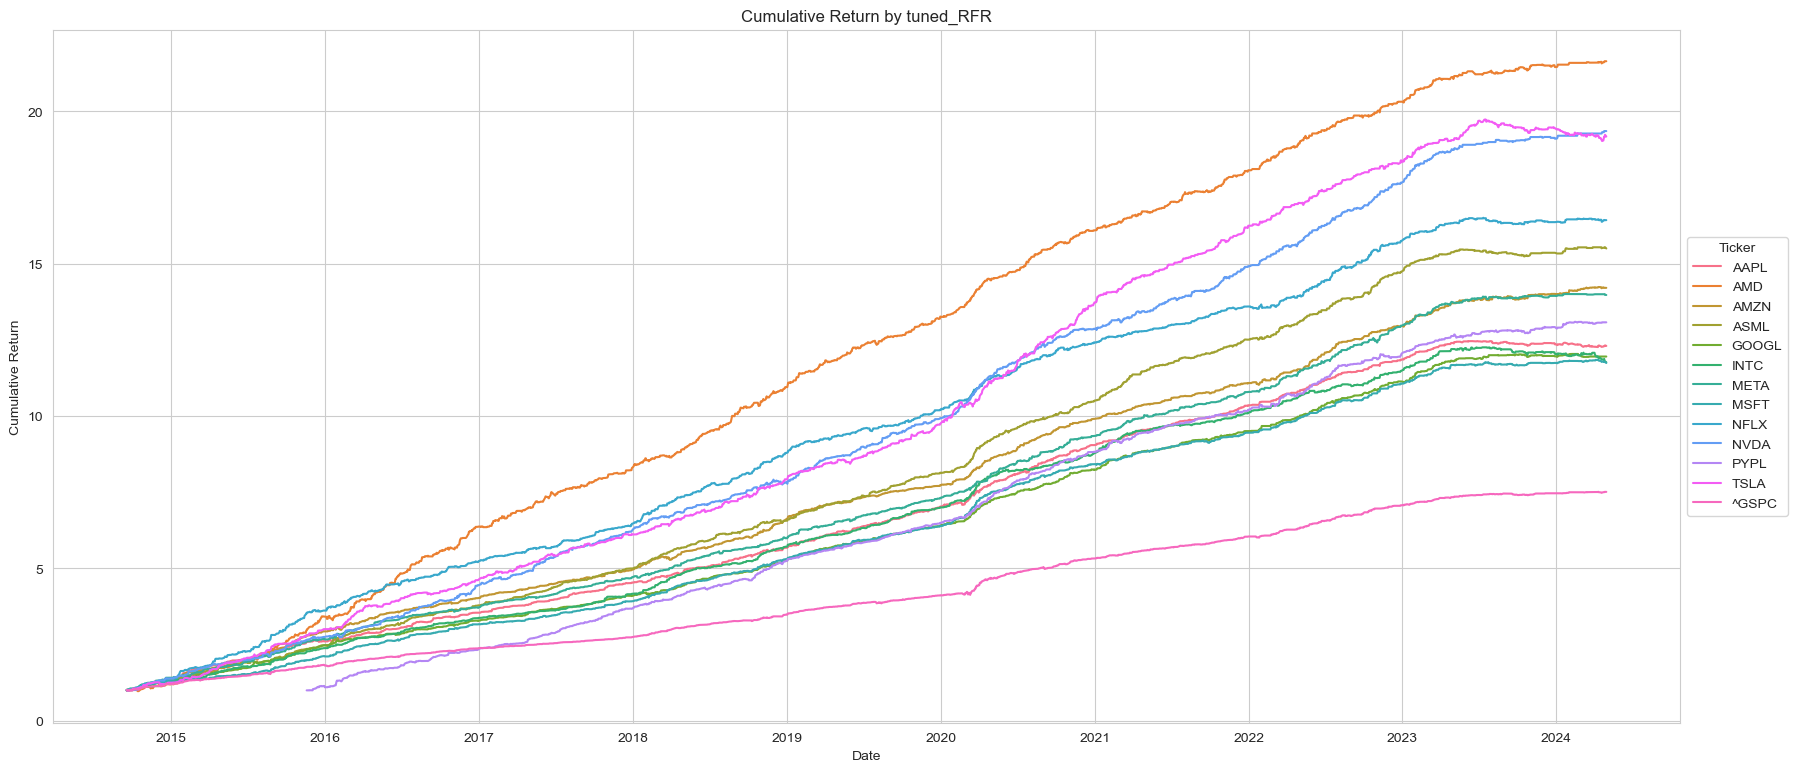

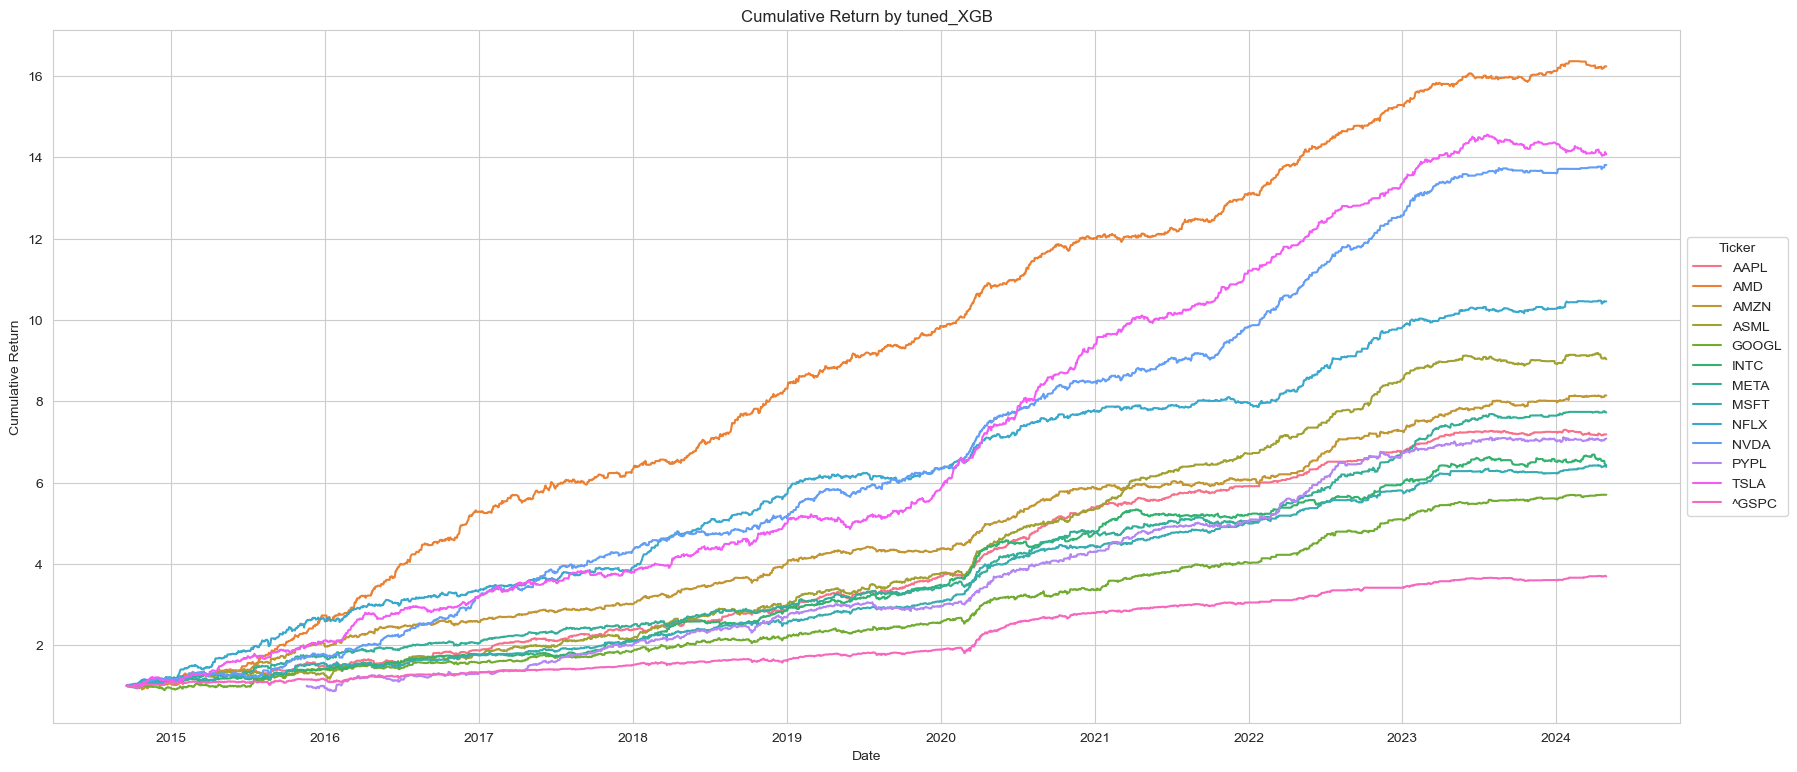

In [99]:
# Plot Cumulative return each model
for model_name in all_models:
    plt.figure(figsize=(21, 9))
    sns.lineplot(data=df_cumulative_return.reset_index(), x='Date', y=f'cumulative_return_{model_name}', hue='Ticker')
    plt.legend(title='Ticker', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Cumulative Return by {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()